**Input: MAGMA gene analysis results**

**Phenotypes**

- Sleep-related

327 Sleep disorders

327.3 Sleep apnea

1160 Sleep duration

1170 Getting up in morning

1180 Morning/evening person (chronotype)

1190 Nap during day

1200 Sleeplessness / insomnia

1220 Daytime dozing / sleeping (narcolepsy)

20517 Trouble falling or staying asleep, or sleeping too much

20533 Trouble falling asleep

G47 Sleep disorders



**Process: calculate the following**
 - Bonferroni-corrected P-values (also written P-Bonf)
 - q-values (also known as FDR-adjusted p-values)
 - Annotation of whether those values are under FDR threshold

**Output: a .csv file with q-values added for each phenotype**

# Preparation (Execute all in this section!)

## Import libraries & set environment variables

In [1]:
import collections
from datetime import datetime
import os
import numpy as np
from pathlib import Path
import polars as pl
import re
import textwrap

import warnings
# suppress DeprecationWarning messages
warnings.filterwarnings("ignore", category=DeprecationWarning)

from matplotlib import pyplot as plt
from matplotlib_venn import venn2
from matplotlib_venn import venn3

dir_home = Path(os.getcwd()).parent.parent.parent
os.chdir(dir_home)
print("Current directory (check that it's your home directory):", os.getcwd())

Current directory (check that it's your home directory): J:\sugai\UKBiobank


In [2]:
DIR_SOURCE = os.path.join("analysis", "panukbb_magma")
DIR_OUT = os.path.join("analysis", "specific", "analysis_20230414_01_sleep_genebasedP")

if not os.path.exists(DIR_OUT):
    os.makedirs(DIR_OUT)


#FILE_OLD_ANALYSIS = os.path.join("panukbb", "analysis", "analysis_20230228_03", "gene_pheno.csv")
FILE_PHENOTYPES = os.path.join("analysis", "20230317_sleep_related.txt")

FDR_THRESHOLD = 0.05 # Q value threshold

## Functions

In [3]:
def flatten(l):
    for el in l:
        if isinstance(el, collections.abc.Iterable) and not isinstance(el, (str, bytes)):
            yield from flatten(el)
        else:
            yield el


def func_print(i):
    if i < 10 or str(i)[1:].count('0') == len(str(i))-1:
        now = datetime.now()
        print(f"{now.strftime('%Y-%m-%d %H:%M:%S')}: {i}")
        

def func_process(FILE_SOURCE, FILE_OUTPUT):
    # Read as String to avoid any automatic conversion
    df = (pl.read_csv(FILE_SOURCE, 
                      sep=" ", 
                      infer_schema_length=0)
          .with_column(pl.col("P").cast(pl.Float32).alias("P_Bonf"))
          .with_column(pl.col("P").cast(pl.Float32).alias("P_log10"))
          .with_column(pl.col("P").cast(pl.Float32).alias("Q"))
          .with_columns(np.log10(pl.col("P_log10")))
          .sort(by='Q'))

    n_count = df['Q'].is_not_null().sum()

    df = (df
          # Calculate Bonferroni-corrected P values
          .with_columns(pl.col('P_Bonf') * n_count)
           # create a new column which is true if "P_Bonf" is under threshold
          .with_column((pl.col("P_Bonf") < FDR_THRESHOLD).alias("Positive_P_Bonf"))
          # Calculate Q values
          # Multiply Q column by number of non-null values
          .with_columns(pl.col('Q') * n_count)
          # # Divide the Q columns by the rank of individual value among all the non-null values
          .with_column(pl.col('Q') / df['Q'].rank())
          # create a new column which is true if "q" is under threshold
          .with_column((pl.col("Q") < FDR_THRESHOLD).alias("Positive_Q"))
          # Add log10 values
          .with_column(pl.col("P_Bonf").alias("P_Bonf_log10"))
          .with_columns(np.log10(pl.col("P_Bonf_log10")))
          .with_column(pl.col("Q").alias("Q_log10"))
          .with_columns(np.log10(pl.col("Q_log10")))
          # Sort
          .sort(by='Positive_P_Bonf', reverse=True)
         )

    df.write_csv(FILE_OUTPUT)

In [24]:
def func_list_genes(pheno_id, l_files_IO):
    # Data position/location
    file_new = [l[1] for l in l_files_IO if pheno_id in l[1]]
    print("Process pheno_id, file =", pheno_id, file_new)
    
    # If the next step fails, just return empty sets
    set_genes_new = set()

    x_full = False # Boolean, TRUE if all the results are not empty
    
    # Proceed if there's a corresponding NEW statistics
    if (len(file_new) == 1):
        file_new = file_new[0]
        # Fetch the names of positive genes
        df_new = (pl.read_csv(file_new)
              .filter(pl.col("Positive_P_Bonf"))
             )
        set_genes_new = set(df_new["NAME"])
    
    # TRUE if all the results are not empty
    if (set_genes_new != set()):      
        x_full = True

    print(len(set_genes_new), "genes found")
    print("")
    return set_genes_new, x_full
        

# Combine the gene list for a set of phenotypes specified in `l_pheno`
def func_group_genes(l_pheno, l_files_IO):
    i = 0
    set_genes_new = set()
    for pheno_id in l_pheno:
        print(pheno_id)
        set_genes_new_2, x_full = func_list_genes(
            pheno_id, l_files_IO)
        if (i == 0):
            if x_full:
                set_genes_new = set_genes_new_2
                i = 1
        else:
            if x_full:
                set_genes_new = set_genes_new | set_genes_new_2

    return set_genes_new

## Prepare the list of files (input/output)

In [20]:
l_files_IO = []

# Recursive directory traversal using os.walk
for root, dirs, files in os.walk(DIR_SOURCE):
    # Iterate through all files in current directory
    for file in files:
        # Check if file name contains "out.with_gene_name.txt"
        if "out.with_gene_name.txt" in file:
            # Print the full path to the file
            l = [os.path.join(root, file), os.path.join(root, "out.with_p_correction.csv")]
            l_files_IO.append(l)

l_files_IO

[['analysis\\panukbb_magma\\continuous-1170-both_sexes\\out.with_gene_name.txt',
  'analysis\\panukbb_magma\\continuous-1170-both_sexes\\out.with_p_correction.csv'],
 ['analysis\\panukbb_magma\\continuous-1180-both_sexes\\out.with_gene_name.txt',
  'analysis\\panukbb_magma\\continuous-1180-both_sexes\\out.with_p_correction.csv'],
 ['analysis\\panukbb_magma\\categorical-20533-both_sexes-20533\\out.with_gene_name.txt',
  'analysis\\panukbb_magma\\categorical-20533-both_sexes-20533\\out.with_p_correction.csv'],
 ['analysis\\panukbb_magma\\biomarkers-30600-both_sexes-irnt\\out.with_gene_name.txt',
  'analysis\\panukbb_magma\\biomarkers-30600-both_sexes-irnt\\out.with_p_correction.csv'],
 ['analysis\\panukbb_magma\\continuous-20517-both_sexes\\out.with_gene_name.txt',
  'analysis\\panukbb_magma\\continuous-20517-both_sexes\\out.with_p_correction.csv'],
 ['analysis\\panukbb_magma\\phecode-327-both_sexes\\out.with_gene_name.txt',
  'analysis\\panukbb_magma\\phecode-327-both_sexes\\out.with_p_

### Get the information of phenotypes

In [6]:
df_phenoptypes = (pl.read_csv(FILE_PHENOTYPES, sep="\t", has_header=False)
                 .rename({'column_1': 'ID',
                          'column_2': 'Phenotype',
                          'column_3': 'Category',
                          'column_4': 'Subcategory',
                          'column_5': 'File_name',
                         })
                 )
df_phenoptypes

ID,Phenotype,Category,Subcategory,File_name
str,str,str,str,str
"""327""","""Sleep disorder...","""sleep-related""","""sleep_general""","""phecode-327-bo..."
"""327.3""","""Sleep apnea""","""sleep-related""","""sleep_general""","""phecode-327.3-..."
"""1160""","""Sleep duration...","""sleep-related""","""sleep_duration...","""continuous-116..."
"""1170""","""Getting up in ...","""sleep-related""","""chronotype""","""continuous-117..."
"""1180""","""Morning/evenin...","""sleep-related""","""chronotype""","""continuous-118..."
"""1190""","""Nap during day...","""sleep-related""","""sleep_stabilit...","""continuous-119..."
"""1200""","""Sleeplessness ...","""sleep-related""","""sleep_general""","""continuous-120..."
"""1220""","""Daytime dozing...","""sleep-related""","""sleep_stabilit...","""continuous-122..."
"""20517""","""Trouble fallin...","""sleep-related""","""sleep_general""","""continuous-205..."


In [7]:
# Chronotype-related phenotypes
l_pheno_chronotype = list(set(df_phenoptypes
                      .filter(pl.col("Subcategory") == "chronotype")
                      ["ID"]
                     ))

# Specific sleep phenotypes
l_pheno_sleep_specific = list(set(df_phenoptypes
                      .filter(pl.col("Subcategory") == "sleep_stability")
                      ["ID"]
                     )) + list(set(df_phenoptypes
                      .filter(pl.col("Subcategory") == "sleep_duration")
                      ["ID"]
                     ))

# General sleep phenotypes
l_pheno_sleep_general = list(set(df_phenoptypes
                      .filter(pl.col("Subcategory") == "sleep_general")
                      ["ID"]
                     ))

l_pheno_sleep_all = list(set(l_pheno_sleep_general + l_pheno_sleep_specific))

print(l_pheno_chronotype)
print(l_pheno_sleep_specific)
print(l_pheno_sleep_general)
print(l_pheno_sleep_all)

['1170', '1180']
['1190', '1220', '1160']
['1200', 'G47', '20517', '20533', '327', '327.3']
['1200', 'G47', '1190', '1160', '20517', '1220', '20533', '327', '327.3']


# Process

## Add Pbonf, q-values, posi/nega annotation

In [12]:
for l in l_files_IO:
    print("Process", l[0], "->", l[1])
    func_process(l[0], l[1])

Process analysis\panukbb_magma\continuous-1170-both_sexes\out.with_gene_name.txt -> analysis\panukbb_magma\continuous-1170-both_sexes\out.with_p_correction.csv


D:\soft\Anaconda\envs\py3full\lib\site-packages\polars\internals\series\series.py:969: RuntimeWarning: divide by zero encountered in log10
  series = f(lambda out: ufunc(*args, out=out, dtype=dtype_char, **kwargs))


Process analysis\panukbb_magma\continuous-1180-both_sexes\out.with_gene_name.txt -> analysis\panukbb_magma\continuous-1180-both_sexes\out.with_p_correction.csv
Process analysis\panukbb_magma\categorical-20533-both_sexes-20533\out.with_gene_name.txt -> analysis\panukbb_magma\categorical-20533-both_sexes-20533\out.with_p_correction.csv
Process analysis\panukbb_magma\biomarkers-30600-both_sexes-irnt\out.with_gene_name.txt -> analysis\panukbb_magma\biomarkers-30600-both_sexes-irnt\out.with_p_correction.csv
Process analysis\panukbb_magma\continuous-20517-both_sexes\out.with_gene_name.txt -> analysis\panukbb_magma\continuous-20517-both_sexes\out.with_p_correction.csv
Process analysis\panukbb_magma\phecode-327-both_sexes\out.with_gene_name.txt -> analysis\panukbb_magma\phecode-327-both_sexes\out.with_p_correction.csv
Process analysis\panukbb_magma\continuous-1220-both_sexes\out.with_gene_name.txt -> analysis\panukbb_magma\continuous-1220-both_sexes\out.with_p_correction.csv
Process analysis\p

## Venn's diagram

### List up the genes corresponding to the phenotypes

In [25]:
set_genes_new_chronotype = \
func_group_genes(l_pheno_chronotype, l_files_IO)

set_genes_new_sleep = \
func_group_genes(l_pheno_sleep_all, l_files_IO)

print(len(set_genes_new_chronotype), len(set_genes_new_sleep))

1170
Process pheno_id, file = 1170 ['analysis\\panukbb_magma\\continuous-1170-both_sexes\\out.with_p_correction.csv']
168 genes found

1180
Process pheno_id, file = 1180 ['analysis\\panukbb_magma\\continuous-1180-both_sexes\\out.with_p_correction.csv']
270 genes found

1200
Process pheno_id, file = 1200 ['analysis\\panukbb_magma\\continuous-1200-both_sexes\\out.with_p_correction.csv']
92 genes found

G47
Process pheno_id, file = G47 ['analysis\\panukbb_magma\\icd10-G47-both_sexes\\out.with_p_correction.csv']
0 genes found

1190
Process pheno_id, file = 1190 ['analysis\\panukbb_magma\\continuous-1190-both_sexes\\out.with_p_correction.csv']
161 genes found

1160
Process pheno_id, file = 1160 ['analysis\\panukbb_magma\\continuous-1160-both_sexes\\out.with_p_correction.csv']
103 genes found

20517
Process pheno_id, file = 20517 ['analysis\\panukbb_magma\\continuous-20517-both_sexes\\out.with_p_correction.csv']
0 genes found

1220
Process pheno_id, file = 1220 ['analysis\\panukbb_magma\\con

### Draw Venn diagrams

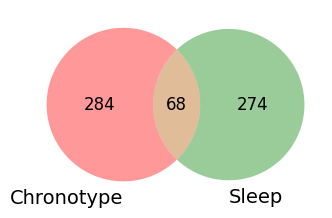

In [27]:
# Draw Venn diagrams - 2 sets
def func_venn2(set_genes_chronotype, set_genes_sleep_all):
    plt.rcParams["figure.figsize"] = [3.5, 3.5]
    plt.rcParams["figure.autolayout"] = True

    out = venn2([set_genes_chronotype, set_genes_sleep_all], 
          ('Chronotype', 'Sleep'))
    
    for text in out.set_labels:
        text.set_fontsize(14)
    try: # Sometimes it fails because no intersect exists
        for text in out.subset_labels:
            text.set_fontsize(12)
    except:
        pass
    plt.show()

func_venn2(set_genes_new_chronotype, set_genes_new_sleep)

Process pheno_id, file = 1200 ['analysis\\panukbb_magma\\continuous-1200-both_sexes\\out.with_p_correction.csv']
92 genes found



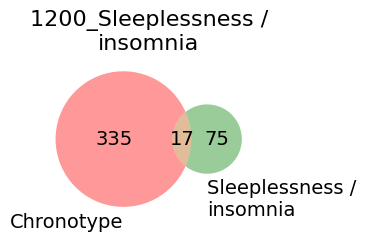

Process pheno_id, file = G47 ['analysis\\panukbb_magma\\icd10-G47-both_sexes\\out.with_p_correction.csv']
0 genes found

Empty set
Process pheno_id, file = 1190 ['analysis\\panukbb_magma\\continuous-1190-both_sexes\\out.with_p_correction.csv']
161 genes found



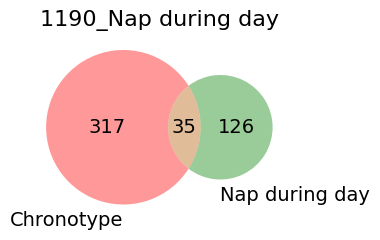

Process pheno_id, file = 1160 ['analysis\\panukbb_magma\\continuous-1160-both_sexes\\out.with_p_correction.csv']
103 genes found



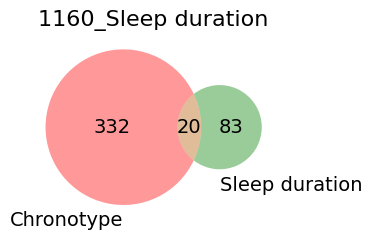

Process pheno_id, file = 20517 ['analysis\\panukbb_magma\\continuous-20517-both_sexes\\out.with_p_correction.csv']
0 genes found

Empty set
Process pheno_id, file = 1220 ['analysis\\panukbb_magma\\continuous-1220-both_sexes\\out.with_p_correction.csv']
57 genes found



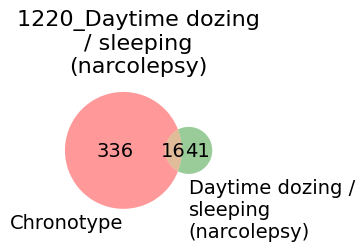

Process pheno_id, file = 20533 ['analysis\\panukbb_magma\\categorical-20533-both_sexes-20533\\out.with_p_correction.csv']
10 genes found



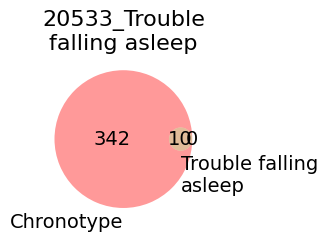

Process pheno_id, file = 327 ['analysis\\panukbb_magma\\phecode-327-both_sexes\\out.with_p_correction.csv', 'analysis\\panukbb_magma\\phecode-327.3-both_sexes\\out.with_p_correction.csv']
0 genes found

Empty set
Process pheno_id, file = 327.3 ['analysis\\panukbb_magma\\phecode-327.3-both_sexes\\out.with_p_correction.csv']
1 genes found



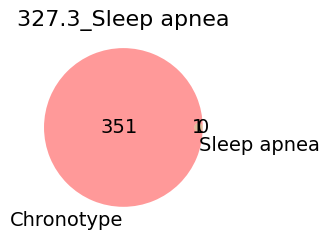

In [28]:
# Draw Venn diagrams - 2 sets
def func_venn2_each(set_genes_chronotype, set_genes_sleep, pheno_id, pheno_name):
    plt.rcParams["figure.figsize"] = [7, 2.5]
    plt.rcParams["figure.autolayout"] = True
    
    pheno = pheno_id + "_" + pheno_name
    wrapper = textwrap.TextWrapper(width=20, break_long_words=False)
    pheno = wrapper.fill(text=pheno)
    pheno_name = wrapper.fill(text=pheno_name)
    
    plt.title(pheno, fontsize = 16)

    out = venn2([set_genes_chronotype, set_genes_sleep], 
          ('Chronotype', pheno_name))
    
    for text in out.set_labels:
        text.set_fontsize(14)
    try: # Sometimes it fails because no intersect exists
        for text in out.subset_labels:
            text.set_fontsize(14)
    except:
        pass
    plt.show()
    
for pheno_id in l_pheno_sleep_all:
    set_genes_new, x_full = func_list_genes(
        pheno_id, l_files_IO)
    if set_genes_new != set():
        pheno_name = df_phenoptypes.filter(pl.col("ID") == pheno_id)["Phenotype"][0]
        func_venn2_each(set_genes_new_chronotype, set_genes_new, pheno_id, pheno_name)
    else:
        print("Empty set")

### Draw the big 3

In [30]:
l_pheno_id = ["1160", "1190", "1200",]
l_pheno_name = [] # Store the phenotype names
l_set_genes = [] # Store the sets of genes

for pheno_id in l_pheno_id:
    set_genes_new, x_full = func_list_genes(pheno_id, l_files_IO)
    l_set_genes.append(set_genes_new)
    pheno_name = df_phenoptypes.filter(pl.col("ID") == pheno_id)["Phenotype"][0]
    pheno_name = pheno_id + "_" + pheno_name
    l_pheno_name.append(pheno_name)

Process pheno_id, file = 1160 ['analysis\\panukbb_magma\\continuous-1160-both_sexes\\out.with_p_correction.csv']
103 genes found

Process pheno_id, file = 1190 ['analysis\\panukbb_magma\\continuous-1190-both_sexes\\out.with_p_correction.csv']
161 genes found

Process pheno_id, file = 1200 ['analysis\\panukbb_magma\\continuous-1200-both_sexes\\out.with_p_correction.csv']
92 genes found



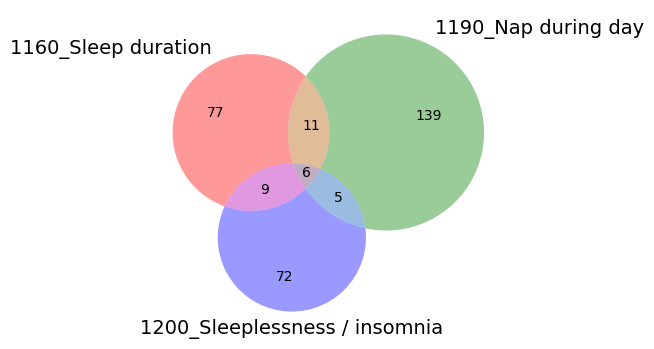

In [31]:
plt.rcParams["figure.figsize"] = [6, 5]
plt.rcParams["figure.autolayout"] = True

out = venn3(l_set_genes, l_pheno_name)

for text in out.set_labels:
    text.set_fontsize(14)
for text in out.subset_labels:
    text.set_fontsize(10)
plt.show()

# Make a single united file of gene-phenotype combinations

In [35]:
l_combinations = []

for l in l_files_IO:
    print("Processing", l)
    # Get the list of positive genes for a phenotype (l[1])
    file_new = l[1]
    df_new = (pl.read_csv(file_new)
          .filter(pl.col("Positive_P_Bonf"))
         )
    set_genes_new = set(df_new["NAME"])

    # Get the phenotype name
    pheno_id = re.sub("\\\out.with_p_correction.csv", "", file_new)
    pheno_id = re.sub(".*\\\\", "", pheno_id)
    annot = df_phenoptypes.filter(pl.col("File_name") == pheno_id)
    
    # Append if not empty
    if len(annot) > 0:
        annot = [x[0] for x in annot]
        # Store in the list
        l_combinations.append([pheno_id, annot, list(set_genes_new)])

Processing ['analysis\\panukbb_magma\\continuous-1170-both_sexes\\out.with_gene_name.txt', 'analysis\\panukbb_magma\\continuous-1170-both_sexes\\out.with_p_correction.csv']
Processing ['analysis\\panukbb_magma\\continuous-1180-both_sexes\\out.with_gene_name.txt', 'analysis\\panukbb_magma\\continuous-1180-both_sexes\\out.with_p_correction.csv']
Processing ['analysis\\panukbb_magma\\categorical-20533-both_sexes-20533\\out.with_gene_name.txt', 'analysis\\panukbb_magma\\categorical-20533-both_sexes-20533\\out.with_p_correction.csv']
Processing ['analysis\\panukbb_magma\\biomarkers-30600-both_sexes-irnt\\out.with_gene_name.txt', 'analysis\\panukbb_magma\\biomarkers-30600-both_sexes-irnt\\out.with_p_correction.csv']
Processing ['analysis\\panukbb_magma\\continuous-20517-both_sexes\\out.with_gene_name.txt', 'analysis\\panukbb_magma\\continuous-20517-both_sexes\\out.with_p_correction.csv']
Processing ['analysis\\panukbb_magma\\phecode-327-both_sexes\\out.with_gene_name.txt', 'analysis\\panukbb

In [36]:
l_combinations[0]

['continuous-1170-both_sexes',
 ['1170',
  'Getting up in morning',
  'sleep-related',
  'chronotype',
  'continuous-1170-both_sexes'],
 ['MRPS21',
  'FAT3',
  'VAMP3',
  'CALN1',
  'STAC3',
  'CPNE8',
  'KIF3B',
  'FTO',
  'ZBTB1',
  'PMFBP1',
  'NRXN1',
  'PRPF3',
  'VRK2',
  'SNRNP27',
  'PLEKHM1',
  'NSF',
  'C17orf50',
  'LOC101927844',
  'EXD3',
  'HCRTR2',
  'GPR61',
  'SCRN2',
  'ASIC2',
  'RABGAP1L',
  'NDUFS3',
  'CIART',
  'ST18',
  'AADAT',
  'AGPAT1',
  'KIF5A',
  'SCNN1G',
  'ARHGAP27',
  'BTBD18',
  'MED24',
  'ZNF664',
  'GNAI3',
  'PER3',
  'CRHR1',
  'RSC1A1',
  'RNF5',
  'POU2F2',
  'PRRC2A',
  'UTS2',
  'AKAP5',
  'NEK6',
  'BAG6',
  'ARL17A',
  'EIF2AK3',
  'CA14',
  'CCDC92',
  'DDI2',
  'RASSF1',
  'AK5',
  'RBFOX1',
  'RORA',
  'STON1-GTF2A1L',
  'TCF4',
  'SELO',
  'ZFP82',
  'STON1',
  'RGS16',
  'TTC8',
  'ATXN1L',
  'RASD1',
  'WNT3',
  'HYAL1',
  'EGFL8',
  'TMX2',
  'PREPL',
  'PLEKHM2',
  'SEMA3B',
  'TMEM115',
  'CRY1',
  'EPHA5',
  'OR9Q1',
  'FBXL3',
 

In [37]:
# Get the list of all genes included in any of the phenotypes
l_genes = [l[2] for l in l_combinations]
# flatten, remove duplicates, and sort
l_genes = sorted(list(set(list(flatten(l_genes)))))
l_genes

['AADAT',
 'AAK1',
 'ACACA',
 'ACBD4',
 'ADGRL4',
 'ADHFE1',
 'ADO',
 'ADRA1D',
 'AGAP1',
 'AGBL1',
 'AGER',
 'AGPAT1',
 'AK5',
 'AKAP5',
 'ALG10',
 'ALG10B',
 'ALKBH4',
 'AMIGO3',
 'ANKFY1',
 'ANKK1',
 'ANKS1B',
 'ANP32E',
 'AP2B1',
 'AP3B2',
 'APC',
 'APOE',
 'ARHGAP15',
 'ARHGAP27',
 'ARHGEF18',
 'ARID2',
 'ARIH2',
 'ARL17A',
 'ARL17B',
 'ARNT',
 'AS3MT',
 'ASB1',
 'ASCC3',
 'ASIC2',
 'ASXL1',
 'ATAD2B',
 'ATE1',
 'ATP5J2-PTCD1',
 'ATXN1L',
 'AUTS2',
 'AVIL',
 'AXDND1',
 'AZIN1',
 'BAG6',
 'BAIAP2',
 'BCAP29',
 'BEGAIN',
 'BHLHE22',
 'BLK',
 'BOLL',
 'BRPF3',
 'BSN',
 'BTBD1',
 'BTBD18',
 'BTBD9',
 'BTN2A1',
 'BTN3A2',
 'BTN3A3',
 'C10orf32',
 'C11orf31',
 'C11orf80',
 'C15orf61',
 'C17orf50',
 'C18orf42',
 'C1QB',
 'C1QTNF4',
 'C1orf110',
 'C1orf54',
 'C2orf44',
 'C2orf47',
 'C3orf18',
 'C3orf84',
 'C6orf48',
 'C9orf163',
 'C9orf64',
 'CA10',
 'CA11',
 'CA14',
 'CACNA2D2',
 'CACYBP',
 'CADM2',
 'CALML6',
 'CALN1',
 'CAMKMT',
 'CAMKV',
 'CAMTA1',
 'CAPZA1',
 'CARD9',
 'CCAR1',
 'CCD

limit_output extension: Maximum message size of 5000 exceeded with 6511 characters

In [38]:
# Make a 2-d matrix from the 1-d list `l_combinations`
df_combinations = pl.DataFrame(l_genes, columns=["Gene"])

# Loop through each phenotype in a list of phenotypes
for l in l_combinations:
    pheno = l[0]

    # Add a new column to a dataframe called 'df_combinations'
    # with values initialized to 0,
    # and alias it to the current phenotype
    df_combinations = df_combinations.with_column(pl.lit(0).alias(pheno))
    
    # Create a temporary list of genes associated with the current phenotype
    l_genes_temp = [l[2] for l in l_combinations if l[0] == pheno]

    # Remove duplicates from the list of genes and sort the list in ascending order
    l_genes_temp = sorted(list(set(list(flatten(l_genes_temp)))))
    
    # Add a new column to the dataframe called 'df_combinations'
    # by applying a lambda function to each value in the 'Gene' column.
    # The lambda function checks whether the current gene is
    # in the temporary list of genes associated with the current phenotype.
    # The resulting boolean value is then cast to an integer and aliased to the current phenotype.
    df_combinations = df_combinations.with_column(
        pl.col("Gene").apply(lambda x: int(x in l_genes_temp)).
        cast(pl.Int32).alias(pheno)
    )

# convert all columns to str
df_combinations = df_combinations.select([pl.col(c).cast(str) for c in df_combinations.columns])

# Add annotations
l_row_names = ["id", "Phenotype", 'Category', 'Subcategory', 'File_name',]

for i, row_name in enumerate(l_row_names):
    new_row = [row_name] + [l[1][i] for l in l_combinations]
    # add the new row to the Polars DataFrame
    df_combinations = pl.concat(
        [pl.DataFrame([new_row], columns=df_combinations.columns),
         df_combinations])

FILE_OUTPUT = os.path.join(DIR_OUT, "gene_pheno_new.csv")
df_combinations.write_csv(FILE_OUTPUT)
df_combinations

Gene,continuous-1170-both_sexes,continuous-1180-both_sexes,categorical-20533-both_sexes-20533,continuous-20517-both_sexes,phecode-327-both_sexes,continuous-1220-both_sexes,icd10-G47-both_sexes,phecode-327.3-both_sexes,continuous-1200-both_sexes,continuous-1190-both_sexes,continuous-1160-both_sexes
str,str,str,str,str,str,str,str,str,str,str,str
"""File_name""","""continuous-117...","""continuous-118...","""categorical-20...","""continuous-205...","""phecode-327-bo...","""continuous-122...","""icd10-G47-both...","""phecode-327.3-...","""continuous-120...","""continuous-119...","""continuous-116..."
"""Subcategory""","""chronotype""","""chronotype""","""sleep_general""","""sleep_general""","""sleep_general""","""sleep_stabilit...","""sleep_general""","""sleep_general""","""sleep_general""","""sleep_stabilit...","""sleep_duration..."
"""Category""","""sleep-related""","""sleep-related""","""sleep-related""","""sleep-related""","""sleep-related""","""sleep-related""","""sleep-related""","""sleep-related""","""sleep-related""","""sleep-related""","""sleep-related"""
"""Phenotype""","""Getting up in ...","""Morning/evenin...","""Trouble fallin...","""Trouble fallin...","""Sleep disorder...","""Daytime dozing...","""Sleep disorder...","""Sleep apnea""","""Sleeplessness ...","""Nap during day...","""Sleep duration..."
"""id""","""1170""","""1180""","""20533""","""20517""","""327""","""1220""","""G47""","""327.3""","""1200""","""1190""","""1160"""
"""AADAT""","""1""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0"""
"""AAK1""","""1""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0"""
"""ACACA""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""1""","""0"""
"""ACBD4""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""1""","""1""","""0"""


limit_output extension: Maximum message size of 5000 exceeded with 9132 characters

# Make a single united file of gene-based P-values
Filter for sleep-related phenotype

In [40]:
# Aggregate
for i, l in enumerate(l_files_IO):
    print("Processing", l)
    # Get the list of positive genes for a phenotype (l[1])
    file_new = l[1]
    
    # Get the phenotype name
    pheno_id = re.sub("\\\out.with_p_correction.csv", "", file_new)
    pheno_id = re.sub(".*\\\\", "", pheno_id)
    annot = df_phenoptypes.filter(pl.col("File_name") == pheno_id)

    if (len(annot) > 0):
        annot = [x[0] for x in annot]

        # Reshape the data
        df_new = (pl.read_csv(file_new)
              .filter(pl.col("Positive_P_Bonf"))
                  [["NAME", "P_Bonf_log10"]]
                  .with_column(pl.lit(annot[0]).alias("id"))
                  .with_column(pl.lit(annot[1]).alias("Phenotype"))
                  .with_column(pl.lit(annot[2]).alias("Category"))
                  .with_column(pl.lit(annot[3]).alias("Subcategory"))
                  .with_column(pl.lit(annot[4]).alias("File_name"))
             )    

        # Aggregate
        if (i==0):
            df_pval = df_new
        else:
            df_pval = pl.concat([df_pval, df_new])

            
x_first_entry = True

# Filter sleep phenotype
df_result = (df_pval
             .filter(pl.col("Subcategory").str.contains("sleep"))
             .sort(by='NAME')
             # For rows with the same values in "NAME" column,
             # extract only one row with the smalles value in "P_Bonf_log10" column,
             # with all the other corresponding columns in the same row
             .groupby("NAME").agg(
                 pl.col("P_Bonf_log10").min().alias("P_Bonf_log10_min")
             ).join(
                 df_pval, left_on=["NAME", "P_Bonf_log10_min"], right_on=["NAME", "P_Bonf_log10"]
             )
            )

FILE_OUTPUT = os.path.join(DIR_OUT, "gene_pheno_pval_list.csv")
df_result.write_csv(FILE_OUTPUT)
df_result

Processing ['analysis\\panukbb_magma\\continuous-1170-both_sexes\\out.with_gene_name.txt', 'analysis\\panukbb_magma\\continuous-1170-both_sexes\\out.with_p_correction.csv']
Processing ['analysis\\panukbb_magma\\continuous-1180-both_sexes\\out.with_gene_name.txt', 'analysis\\panukbb_magma\\continuous-1180-both_sexes\\out.with_p_correction.csv']
Processing ['analysis\\panukbb_magma\\categorical-20533-both_sexes-20533\\out.with_gene_name.txt', 'analysis\\panukbb_magma\\categorical-20533-both_sexes-20533\\out.with_p_correction.csv']
Processing ['analysis\\panukbb_magma\\biomarkers-30600-both_sexes-irnt\\out.with_gene_name.txt', 'analysis\\panukbb_magma\\biomarkers-30600-both_sexes-irnt\\out.with_p_correction.csv']
Processing ['analysis\\panukbb_magma\\continuous-20517-both_sexes\\out.with_gene_name.txt', 'analysis\\panukbb_magma\\continuous-20517-both_sexes\\out.with_p_correction.csv']
Processing ['analysis\\panukbb_magma\\phecode-327-both_sexes\\out.with_gene_name.txt', 'analysis\\panukbb

NAME,P_Bonf_log10_min,id,Phenotype,Category,Subcategory,File_name
str,f64,str,str,str,str,str
"""SPPL2C""",-5.122183,"""1220""","""Daytime dozing...","""sleep-related""","""sleep_stabilit...","""continuous-122..."
"""KSR2""",-4.320257,"""1220""","""Daytime dozing...","""sleep-related""","""sleep_stabilit...","""continuous-122..."
"""BOLL""",-3.665566,"""1220""","""Daytime dozing...","""sleep-related""","""sleep_stabilit...","""continuous-122..."
"""GCKR""",-3.410476,"""1220""","""Daytime dozing...","""sleep-related""","""sleep_stabilit...","""continuous-122..."
"""PLCL1""",-3.353709,"""1220""","""Daytime dozing...","""sleep-related""","""sleep_stabilit...","""continuous-122..."
"""CADM2""",-2.873782,"""1220""","""Daytime dozing...","""sleep-related""","""sleep_stabilit...","""continuous-122..."
"""MAPKAP1""",-2.615851,"""1220""","""Daytime dozing...","""sleep-related""","""sleep_stabilit...","""continuous-122..."
"""CPEB1""",-2.231923,"""1220""","""Daytime dozing...","""sleep-related""","""sleep_stabilit...","""continuous-122..."
"""AP3B2""",-2.160015,"""1220""","""Daytime dozing...","""sleep-related""","""sleep_stabilit...","""continuous-122..."


limit_output extension: Maximum message size of 5000 exceeded with 8238 characters